# Libraries


In [1]:
from copy import deepcopy
from graphviz import Digraph
from queue import Queue, PriorityQueue
import numpy as np
import random
import matplotlib.pyplot as plt

# Node Class

In [5]:
class Node:
  def __init__(self, state_or_id, action=None, parent=None):
    if isinstance(state_or_id, str):
      self.id = state_or_id
      self.state = self.state_from_id(state_or_id)
    else:
      self.state = state_or_id
      self.id = self.id_from_state(state_or_id)
    self.action = action
    self.parent = parent
    self.f_value = 0
    self.g_value = 0

  def __str__(self):
    return self.id

  def __lt__(self, other):
    return self.get_f_value() < other.get_f_value()

  @staticmethod
  def state_from_id(string):
    return [[int(char) if char.isdigit() else 0 for char in row] for row in string.split('\\n')]

  @staticmethod
  def id_from_state(state):
    return '\\n'.join(''.join(str(cell) if cell != 0 else '_' for cell in row) for row in state)

  def set_f_value(self, f_value):
    self.f_value = f_value

  def get_f_value(self):
    return self.f_value

  def set_g_value(self, g_value):
    self.g_value = g_value

  def get_g_value(self):
    return self.g_value

  def get_successors(self):
    successors = []
    for action in ['L', 'R', 'U', 'D']:
        successor_state = self.get_successor(action, deepcopy(self.state))
        if successor_state is not None:
            successors.append(Node(successor_state, action, self))
    return successors

  def get_successor(self, action, state):
    pi, pj = self.get_blank_pos(state)
    pi, pj = self.get_dest_pos(action, pi, pj)
    if 0 <= pi and pi < 3 and 0 <= pj and pj < 3:
      if action == 'L':
        state[pi][pj - 1] = state[pi][pj]
      if action == 'R':
        state[pi][pj + 1] = state[pi][pj]
      if action == 'U':
        state[pi-1][pj] = state[pi][pj]
      if action == 'D':
        state[pi+1][pj] = state[pi][pj]
      state[pi][pj] = 0
      return state
    return None

  def get_dest_pos(self, action, pi, pj):
    if action == 'L':
      pj += 1
    if action == 'R':
      pj -= 1
    if action == 'U':
      pi += 1
    if action == 'D':
      pi -= 1
    return pi, pj

  def get_blank_pos(self, state):
    for i in range(3):
      for j in range(3):
        if state[i][j] == 0:
          return (i, j)
    return None

  def get_id(self):
    return self.id

  def get_node_str(self):
    return str(self)

  def get_action(self):
    return self.action

  def get_parent(self):
    return self.parent

  def get_state(self):
    return self.state

  @staticmethod
  def get_goal_states() -> list:
    return [[[0, 1, 2], [3,4,5], [6, 7, 8]], [[0, 1, 2], [3,4,5], [6, 7, 8]]]

  def goal_test(self):
    return self.get_id() in ['123\\n456\\n78_', '_12\\n345\\n678']

  def draw(self, dot):
    dot.node(self.get_id(), self.get_node_str())
    if self.parent is not None:
      dot.edge(self.parent.get_id(), self.get_id(), self.get_action())

# Search Agents

In [6]:
class search:
  def qualified_states(self, goal_node):
    frontier = Queue()
    frontier.put(goal_node)

    explored = set()

    while not frontier.empty():
      current_node = frontier.get()
      explored.add(current_node.get_id())

      for successor in current_node.get_successors():
        if successor.get_id() not in explored:
          explored.add(successor.get_id())
          frontier.put(successor)

    return explored

  def visualize(self, list_node) -> tuple:
    dot = Digraph()
    path = list()

    while list_node:
      current_node = list_node.pop(0)

      if current_node.get_action() is not None:
        path.append(current_node.get_action())

      current_node.draw(dot)

    return dot, path, len(path)

  def BFS(self, initial_node: Node) -> list:
    frontier = Queue()
    frontier.put((initial_node, [initial_node]))

    explored = set()

    while not frontier.empty():
      current_node, list_node = frontier.get()

      if current_node.goal_test():
        return list_node

      explored.add(current_node.get_id())

      for successor in current_node.get_successors():
        if successor.get_id() not in explored:
          explored.add(successor.get_id())
          frontier.put((successor, list_node + [successor]))

    return []

  def manhattan(self, node: Node):
    min_distance = float('inf')
    state = node.get_state()
    for goal_state in node.get_goal_states():
      distance = 0
      for i in range(len(state)):
        for j in range(len(state[0])):
          cell_value = state[i][j]
          if cell_value != 0:
            goal_position = self.find_position(cell_value, goal_state)
            distance += abs(i - goal_position[0]) + abs(j - goal_position[1])

      min_distance = min(min_distance, distance)

    return min_distance

  def euclidean(self, node: Node):
    min_distance = float('inf')
    state = node.get_state()
    for goal_state in node.get_goal_states():
      distance = 0
      for i in range(len(state)):
        for j in range(len(state[0])):
          cell_value = state[i][j]
          if cell_value != 0:
            goal_position = self.find_position(cell_value, goal_state)
            distance += ((i - goal_position[0]) ** 2 + (j - goal_position[1]) ** 2) ** 0.5

      min_distance = min(min_distance, distance)

    return min_distance

  def find_position(self, value, state):
    for i in range(len(state)):
      for j in range(len(state[0])):
        if state[i][j] == value:
          return (i, j)
    return None

  def A_star(self, initial_node: Node, heuristic_func) -> list:
    frontier = PriorityQueue()
    f_value = heuristic_func(initial_node)
    initial_node.set_f_value(f_value)
    initial_node.set_g_value(0)
    frontier.put((f_value, (initial_node, [initial_node])))

    explored = set()

    while not frontier.empty():
      current_f_value, (current_node, list_node) = frontier.get()
      # print('\n', current_node.get_id(), 'g', current_node.get_g_value(), 'f:', current_f_value)
      if current_node.goal_test():
        return list_node

      explored.add(current_node.get_id())

      for successor in current_node.get_successors():
        if successor.get_id() not in explored:
          explored.add(successor.get_id())
          g_value = current_node.get_g_value() + 1
          h_value = heuristic_func(successor)
          f_value = g_value + h_value
          successor.set_f_value(f_value)
          successor.set_g_value(g_value)
          # print("current:", current_node.get_id(), ' -> ', successor.get_action(), ' -> ', successor.get_id(), ' f:', f_value)

          frontier.put((f_value, (successor, list_node + [successor])))

    return []

# a) Find results with any state using BFS or A* algorithm

In [7]:
def algorithm(initial_node, searcher_chosen, heuristic = None): # (2D list state, algorithm)
  searcher = search()

  if (searcher_chosen == "BFS"):
    list_node = searcher.BFS(initial_node)
  elif (searcher_chosen == "A*"):
    if (heuristic == "manhattan"):
      list_node = searcher.A_star(initial_node, searcher.manhattan)
    elif (heuristic == "euclidean"):
      list_node = searcher.A_star(initial_node, searcher.euclidean)
    else:
      list_node = searcher.A_star(initial_node, searcher.manhattan) # default
  else:
    list_node = searcher.BFS(initial_node) # default

  if (len(list_node) > 0):
    return searcher.visualize(list_node)

  return 'Error: Cannot find the goal state with ' + str(initial_node)

Initial State: [[0, 1, 2], [3, 8, 4], [6, 7, 5]]

 _12\n384\n675 g 0 f: 3.414213562373095
current: _12\n384\n675  ->  L  ->  1_2\n384\n675  f: 5.414213562373095
current: _12\n384\n675  ->  U  ->  312\n_84\n675  f: 5.414213562373095

 1_2\n384\n675 g 1 f: 5.414213562373095
current: 1_2\n384\n675  ->  L  ->  12_\n384\n675  f: 7.414213562373095
current: 1_2\n384\n675  ->  U  ->  182\n3_4\n675  f: 7.23606797749979

 312\n_84\n675 g 1 f: 5.414213562373095
current: 312\n_84\n675  ->  L  ->  312\n8_4\n675  f: 7.23606797749979
current: 312\n_84\n675  ->  U  ->  312\n684\n_75  f: 7.414213562373095

 182\n3_4\n675 g 2 f: 7.23606797749979
current: 182\n3_4\n675  ->  L  ->  182\n34_\n675  f: 7.23606797749979
current: 182\n3_4\n675  ->  R  ->  182\n_34\n675  f: 9.23606797749979
current: 182\n3_4\n675  ->  U  ->  182\n374\n6_5  f: 9.23606797749979

 312\n8_4\n675 g 2 f: 7.23606797749979
current: 312\n8_4\n675  ->  L  ->  312\n84_\n675  f: 7.23606797749979
current: 312\n8_4\n675  ->  U  ->  312\n874\

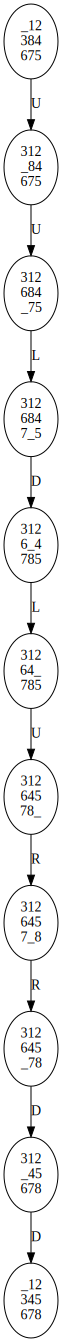

In [11]:
visualize = Digraph()

# test_state = np.random.choice(9, size=(3, 3), replace=False).tolist() # random
# test_state = '345\\n786\\n_12'                                        # str
test_state = [[0, 1, 2], [3, 8, 4], [6, 7, 5]]                          # list 2d

# some test_case
# [[3, 5, 2], [6, 8, 7], [0, 4, 1]]
# [[3, 7, 4], [2, 0, 8], [1, 6, 5]]
# [[0, 1, 2], [3, 8, 4], [6, 7, 5]]
# [[6, 0, 2], [3, 1, 5], [7, 4, 8]] cannot find
# [[5, 8, 3], [7, 1, 0], [2, 6, 4]] cannot find very long

print("Initial State:", test_state)

# result = algorithm(Node(test_state), "BFS")
# result = algorithm(Node(test_state), "A*", "manhattan")
result = algorithm(Node(test_state), "A*", "euclidean")

if isinstance(result, tuple):
    visualize, path, cost = result
    print("Path:", path)
    print("Cost:", cost)
    print("Visualization")
else:
    print(result)

visualize

# b) Calculate the performance of 1000 random starting states

### ■ Find all possible states to achieve the goal state

In [ ]:
searcher = search()
qualified_set1 = searcher.qualified_states(Node([[1, 2, 3], [4, 5, 6], [7, 8, 0]]))
qualified_set2 = searcher.qualified_states(Node([[0, 1, 2], [3, 4, 5], [6, 7, 8]]))
all_qualified_states = qualified_set1 | qualified_set2

print(len(qualified_set1)) # 181440 states
print(len(qualified_set2)) # 181440 states
print(len(all_qualified_states)) # 181440 states

with open('all_qualified_states.txt', 'w') as f:
  for state in all_qualified_states:
    f.write(state + '\n')

print("Saved in 'all_qualified_states.txt'")

181440
181440
181440
Saved in 'all_qualified_states.txt'


### ■ Randomly generate 1000 starting states

In [ ]:
with open('all_qualified_states.txt', 'r') as f:
  lines = f.readlines()

n_random = 5
list_random = random.sample(lines, n_random)

### ■ Solve using BFS and A* algorithms

In [ ]:
searcher = search()

total_cost_BFS = 0
total_cost_Astar_M = 0
total_cost_Astar_E = 0
count = 1

for id in list_random:
  current_node = Node(id.strip('\n'))

  list_node_BFS = searcher.BFS(current_node)
  list_node_Astar_M = searcher.A_star(current_node, searcher.manhattan)
  list_node_Astar_E = searcher.A_star(current_node, searcher.euclidean)

  dot1, path_BFS, cost_BFS = searcher.visualize(list_node_BFS)
  dot2, path_Astar_M, cost_Astar_M = searcher.visualize(list_node_Astar_M)
  dot2, path_Astar_E, cost_Astar_E = searcher.visualize(list_node_Astar_E)

  print(f"\nstate {count}:", id.strip('\n'))
  print("BFS", f"\n Cost: {cost_BFS}", "\n Path:", path_BFS)
  print("A* Mahattan", f"\n Cost: {cost_Astar_M}", "\n Path:", path_Astar_M)
  print("A* Euclidean", f"\n Cost: {cost_Astar_E}", "\n Path:", path_Astar_E)

  total_cost_BFS += cost_BFS
  total_cost_Astar_M += cost_Astar_M
  total_cost_Astar_E += cost_Astar_E
  count += 1


state 1: _15\n462\n738
BFS 
 Cost: 12 
 Path: ['L', 'L', 'U', 'R', 'U', 'L', 'D', 'R', 'D', 'L', 'U', 'U']
A* Mahattan 
 Cost: 30 
 Path: ['U', 'L', 'U', 'R', 'D', 'L', 'D', 'R', 'U', 'L', 'D', 'L', 'U', 'R', 'R', 'D', 'L', 'U', 'L', 'D', 'R', 'R', 'U', 'L', 'D', 'L', 'U', 'R', 'R', 'D']
A* Euclidean 
 Cost: 24 
 Path: ['U', 'L', 'U', 'R', 'D', 'L', 'L', 'D', 'R', 'R', 'U', 'L', 'D', 'L', 'U', 'R', 'R', 'D', 'L', 'U', 'L', 'D', 'R', 'R']

state 2: 134\n72_\n865
BFS 
 Cost: 11 
 Path: ['D', 'R', 'U', 'L', 'U', 'R', 'R', 'D', 'L', 'L', 'U']
A* Mahattan 
 Cost: 37 
 Path: ['R', 'D', 'L', 'U', 'U', 'R', 'R', 'D', 'L', 'D', 'R', 'U', 'L', 'U', 'L', 'D', 'R', 'R', 'U', 'L', 'D', 'L', 'U', 'R', 'D', 'R', 'D', 'L', 'L', 'U', 'U', 'R', 'D', 'L', 'D', 'R', 'R']
A* Euclidean 
 Cost: 59 
 Path: ['R', 'D', 'L', 'U', 'U', 'R', 'R', 'D', 'L', 'D', 'R', 'U', 'L', 'U', 'L', 'D', 'R', 'R', 'U', 'L', 'L', 'D', 'R', 'U', 'R', 'D', 'D', 'L', 'U', 'L', 'D', 'R', 'R', 'U', 'U', 'L', 'D', 'R', 'D', 'L', 'L',

### ■ Total & Average cost of 1000 experiments for each algorithm.

In [ ]:
print(f"BFS \t\t [TotalCost: {total_cost_BFS}] [AvgCost: {total_cost_BFS / n_random}]")
print(f"A* Mahattan \t [TotalCost: {total_cost_Astar_M}] [AvgCost: {total_cost_Astar_M / n_random}]")
print(f"A* Euclidean \t [TotalCost: {total_cost_Astar_E}] [AvgCost: {total_cost_Astar_E / n_random}]")

BFS 		 [TotalCost: 97] [AvgCost: 19.4]
A* Mahattan 	 [TotalCost: 245] [AvgCost: 49.0]
A* Euclidean 	 [TotalCost: 311] [AvgCost: 62.2]


### ■ Visualize to compare the performance of algorithms

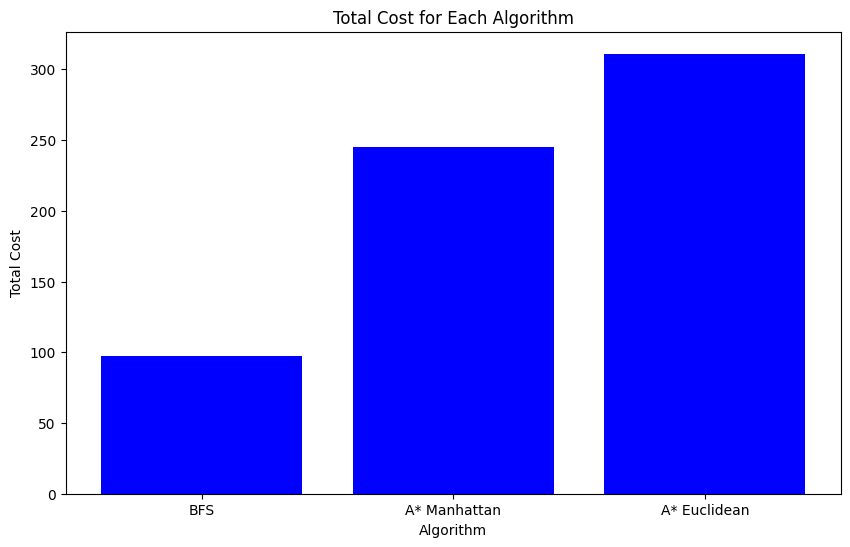

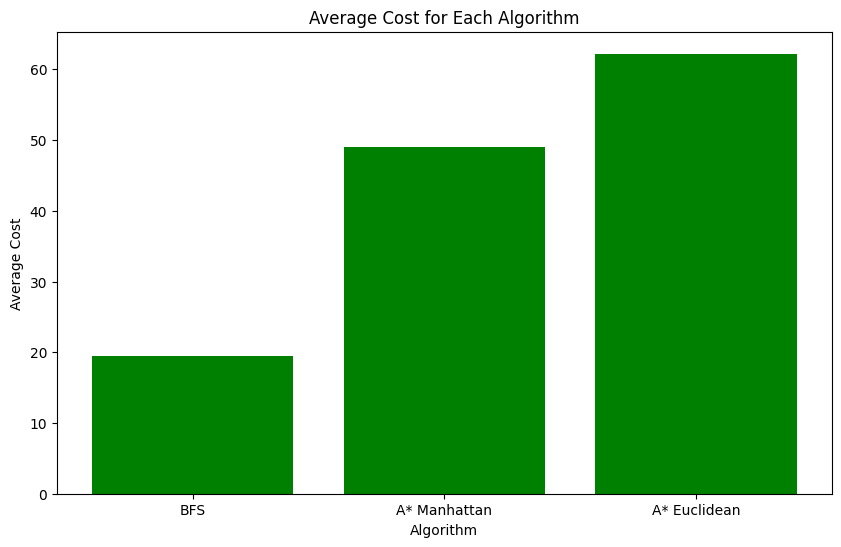

In [ ]:
labels = ['BFS', 'A* Manhattan', 'A* Euclidean']

total_costs = [total_cost_BFS, total_cost_Astar_M, total_cost_Astar_E]
avg_costs = [total_cost_BFS/n_random, total_cost_Astar_M/n_random, total_cost_Astar_E/n_random]

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, total_costs, color='blue')
plt.xlabel('Algorithm')
plt.ylabel('Total Cost')
plt.xticks(x, labels)
plt.title('Total Cost for Each Algorithm')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x, avg_costs, color='green')
plt.xlabel('Algorithm')
plt.ylabel('Average Cost')
plt.xticks(x, labels)
plt.title('Average Cost for Each Algorithm')
plt.show()